In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
class Network(nn.Module):
    def __init__(self, in_channels, num_outputs, base_channels=16):
        super(Network, self).__init__()
        # Convolutional layers that preserve spatial dimensions
        self.conv1 = nn.Conv2d(in_channels, base_channels, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(base_channels, base_channels * 2, kernel_size=3, stride=1, padding=1)

        # The input to the fully connected layer will be the flattened output of the conv layers
        # For a 6x6 grid, the size is (base_channels * 2) * 6 * 6
        flattened_size = base_channels * 2 * 6 * 6
        self.fc1 = nn.Linear(flattened_size, 128)
        self.fc2 = nn.Linear(128, num_outputs)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Input shape: [B, 2, 6, 6]
        x = self.relu(self.conv1(x))  # Shape: [B, 16, 6, 6]
        x = self.relu(self.conv2(x))  # Shape: [B, 32, 6, 6]
        x = x.reshape(x.size(0), -1)      # Shape: [B, 32 * 6 * 6] = [B, 1152]
        x = self.relu(self.fc1(x))    # Shape: [B, 128]
        q_values = self.fc2(x)        # Shape: [B, 4]
        return q_values

    def train_on_batch(self, optimizer, obs, acts, rewards, next_obs, terminals, gamma=0.99):
        next_q_values = self.forward(next_obs)
        max_next_q_values = torch.max(next_q_values, dim=1)[0].detach()

        terminal_mods = 1 - terminals
        actual_qs = rewards + terminal_mods * gamma * max_next_q_values

        pred_qs = self.forward(obs)
        pred_qs = pred_qs.gather(index=acts.view(-1, 1), dim=1).view(-1)

        loss = torch.mean((actual_qs - pred_qs) ** 2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [42]:
model1 = Network(2,4).cuda()
obs = torch.zeros(6,6,2, dtype = torch.float32)

r = 5
c = 0

obs[r][c][0] = 1 # agent is at the buttom left corner
obs[r][c][1] = 1 # it already visited it one time
obs = obs.unsqueeze(0)
obs = obs.permute(0,3,1,2)  #[1,2,6,6]
obs = obs.cuda()
episode_reward = 0
step = 0
print(r,c)
while step < max_steps:

    q_values = model1(obs)
    q_values = q_values.cpu().detach().numpy()
    act = random.randint(0,3)
    next_obs, reward, done = env_step(obs,act)
    episode_reward += reward
    obs = next_obs.cuda()
    print(act)
    step+=1
    if(done):
      break
print(f"steps: {step}")

5 0
1
2
1
3
1
2
3
3
0
0
1
0
1
0
0
0
2
1
0
0
2
1
3
3
3
0
1
2
3
1
1
1
2
2
2
0
0
1
3
2
1
1
2
0
1
1
2
3
1
0
3
3
2
0
1
2
0
1
0
2
3
0
3
1
3
0
0
0
2
1
1
1
0
0
2
2
3
3
2
2
3
2
2
3
0
2
2
2
3
0
2
0
1
3
1
1
2
3
0
1
3
2
1
0
1
3
0
2
3
1
2
2
2
3
3
2
2
1
0
2
0
3
3
2
2
0
0
3
1
3
1
2
1
2
3
2
0
2
0
3
0
1
2
0
0
3
2
0
3
2
0
0
2
1
2
2
1
0
2
1
1
3
0
2
1
0
3
2
1
3
3
3
0
2
2
2
1
3
2
1
1
2
1
3
1
2
2
0
2
3
1
3
3
0
1
3
2
2
3
2
3
3
3
3
3
0
0
3
0
1
2
1
2
1
2
0
3
1
3
0
3
3
0
0
0
2
steps: 226


In [45]:
import math
def env_step(obs, action):

  # if agent tires to go beyond (6,6), ignoring the action and increasing visitation count at that cell
  # find obs[r][c][0] = 1, this means here is the agent
  # make obs[r][c][0] = 0, after taking action agent will not be here
  # 0 = up, 1 = down, 2 = left, 3 = right
  # after taking action let agent reached r',c'. if action is invalid, meaning it goes out of bounds, to take any action
  # increase the count of that state i.e obs[r][c][1] += 1

  # make obs[r'][c'][0] = 1  because agent is here
  # do obs[r'][c'][0] += 1   because agent visited here

  # now return the obs

  obs = obs.clone()
  _, _, H, W = obs.shape
  r, c = torch.where(obs[0, 0] == 1)
  r, c = int(r[0]), int(c[0])

  obs[0, 0, r, c] = 0  # remove agent

  if action == 0 and r > 0: r -= 1
  elif action == 1 and r < H - 1: r += 1
  elif action == 2 and c > 0: c -= 1
  elif action == 3 and c < W - 1: c += 1

  obs[0, 0, r, c] = 1
  obs[0, 1, r, c] += 1

  if obs[0, 1, r, c] == 1:
      reward = 1.0
  else:
      reward = -0.7

  done = False
  visited_states = torch.sum(obs[0, 1] >= 1).item()
  if visited_states >= 35:
      done = True
      reward = 100.0

  return obs, reward, done

In [46]:
class ExperienceReplay():
    def __init__(self, capacity):
        self.capacity = capacity
        self.data = []

    def add_step(self, step_data):
        self.data.append(step_data)
        if len(self.data) > self.capacity:
            self.data.pop(0)

    def sample(self, n):
        n = min(n, len(self.data))
        indices = np.random.choice(range(len(self.data)), n, replace=False)
        samples = [self.data[i] for i in indices]

        # Unzip the list of experiences into separate tuples for each data type
        obs_batch, act_batch, reward_batch, next_obs_batch, terminal_batch = zip(*samples)

        # In your loop, obs and next_obs were saved as numpy arrays with shape (1, 2, 6, 6).
        # np.concatenate joins this list of arrays into a single array of shape (n, 2, 6, 6).
        obs_data = np.stack(obs_batch, axis=0)
        next_obs_data = np.stack(next_obs_batch, axis=0)

        # Convert all data components to the correct PyTorch tensors and move to the GPU
        state_data = torch.tensor(obs_data).float().cuda()
        act_data = torch.tensor(act_batch).long().cuda()
        reward_data = torch.tensor(reward_batch).float().cuda()
        next_state_data = torch.tensor(next_obs_data).float().cuda()
        terminal_data = torch.tensor(terminal_batch).float().cuda()

        return state_data, act_data, reward_data, next_state_data, terminal_data

In [47]:
# obs = torch.zeros(6,6,2, dtype = torch.float32)
# obs[5][0][0] = 1 # agent is at the buttom left corner
# obs[5][0][1] = 1 # it already visited it one time
# obs = obs.unsqueeze(0)
# obs = obs.permute(0,3,1,2)
# global_reward = 0
# for t in range(72):
#   q_values = model(obs)
#   q_values = q_values.cpu().detach().numpy()
#   action = np.argmax(q_values)
#   next_obs,reward,done = env_step(obs, action)
#   obs = next_obs
#   global_reward += reward

In [48]:
er_capacity = 5000
learning_rate = 1e-4
n_episodes = 3500
update_freq = 4
train_batch_size = 32
print_freq = 100
epsilon = lambda step: np.clip(1 - 0.9 * (step / 200000), 0.1, 1) # Decay over more steps
max_steps = 250 # Allow more actions per episode

In [49]:
learning_rate = 1e-4
er = ExperienceReplay(er_capacity)
model = Network(2,4).cuda()
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, eps=1e-6)
all_rewards = []
global_step = 0

for episode in range(n_episodes):

    obs = torch.zeros(6,6,2, dtype = torch.float32)

    r = 5
    c = 0

    obs[r][c][0] = 1 # agent is at the buttom left corner
    obs[r][c][1] = 1 # it already visited it one time
    obs = obs.unsqueeze(0)
    obs = obs.permute(0,3,1,2)  #[1,2,6,6]
    obs = obs.cuda()
    episode_reward = 0
    step = 0
    while step < max_steps:


        if np.random.rand() < epsilon(global_step):
            act = np.random.choice(4)
        else:
            q_values = model(obs)
            q_values = q_values.cpu().detach().numpy()
            act = np.argmax(q_values)

        cumulative_reward = 0

        next_obs, reward, done = env_step(obs,act)
        episode_reward += reward
        er.add_step([obs.squeeze(0).cpu().numpy(), act, reward, next_obs.squeeze(0).cpu().numpy(), int(done)])
        obs = next_obs.cuda()


        if global_step % update_freq == 0:
            obs_data, act_data, reward_data, next_obs_data, terminal_data = er.sample(train_batch_size)
            model.train_on_batch(optimizer, obs_data, act_data, reward_data, next_obs_data, terminal_data)

        step += 1
        global_step += 1

        if done or step >= max_steps:
            break

    all_rewards.append(episode_reward)

    if episode % print_freq == 0:
        print('Episode #{} | Step #{} | Epsilon {:.2f} | Avg. Reward {:.2f}'.format(
            episode, global_step, epsilon(global_step), np.mean(all_rewards[-print_freq:])))

Episode #0 | Step #130 | Epsilon 1.00 | Avg. Reward 62.40
Episode #100 | Step #18092 | Epsilon 0.92 | Avg. Reward 5.00
Episode #200 | Step #34662 | Epsilon 0.84 | Avg. Reward 26.01
Episode #300 | Step #51401 | Epsilon 0.77 | Avg. Reward 28.02
Episode #400 | Step #67188 | Epsilon 0.70 | Avg. Reward 36.76
Episode #500 | Step #81834 | Epsilon 0.63 | Avg. Reward 44.73
Episode #600 | Step #95651 | Epsilon 0.57 | Avg. Reward 54.65
Episode #700 | Step #108972 | Epsilon 0.51 | Avg. Reward 60.15
Episode #800 | Step #122997 | Epsilon 0.45 | Avg. Reward 55.22
Episode #900 | Step #136761 | Epsilon 0.38 | Avg. Reward 54.00
Episode #1000 | Step #150509 | Epsilon 0.32 | Avg. Reward 54.14
Episode #1100 | Step #162800 | Epsilon 0.27 | Avg. Reward 66.34
Episode #1200 | Step #176167 | Epsilon 0.21 | Avg. Reward 55.79
Episode #1300 | Step #189143 | Epsilon 0.15 | Avg. Reward 58.39
Episode #1400 | Step #200884 | Epsilon 0.10 | Avg. Reward 70.21
Episode #1500 | Step #209778 | Epsilon 0.10 | Avg. Reward 91.1

In [ ]:
torch.save(model.state_dict(), 'model.pth')
from google.colab import files
files.download('model.pth')
# ramro sample ni ta buffer ma basnu paryo, so, buffer ma add garesi matra break garne

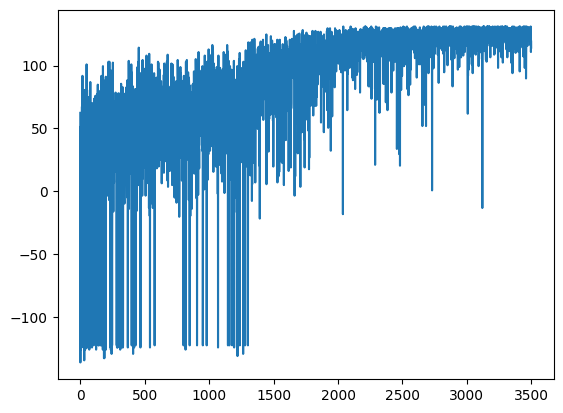

In [50]:
import matplotlib.pyplot as plt
plt.plot(all_rewards)

In [51]:
obs = torch.zeros(6,6,2, dtype = torch.float32)

r = 5
c = 0

obs[r][c][0] = 1 # agent is at the buttom left corner
obs[r][c][1] = 1 # it already visited it one time
obs = obs.unsqueeze(0)
obs = obs.permute(0,3,1,2)  #[1,2,6,6]
obs = obs.cuda()
episode_reward = 0
step = 0
print(r,c)
while step < max_steps:

    q_values = model(obs)
    q_values = q_values.cpu().detach().numpy()
    act = np.argmax(q_values)
    next_obs, reward, done = env_step(obs,act)
    episode_reward += reward
    obs = next_obs.cuda()
    print(act)
    step+=1
    if(done):
      break
print(f"steps: {step}")

5 0
3
3
3
3
3
0
0
0
0
0
2
1
1
1
1
2
2
2
2
0
3
3
3
0
0
0
2
2
1
2
1
3
steps: 32


5 0
tensor(3) 10
tensor(3) 10
tensor(3) 10
tensor(3) 10
tensor(3) 10
tensor(3) 2
tensor(0) 10
tensor(0) 10
tensor(2) 10
tensor(0) 10
tensor(2) 10
tensor(2) 10
tensor(3) 2
tensor(3) 2
tensor(1) 2
tensor(2) 10
tensor(2) 10
tensor(2) 10
tensor(3) 2
tensor(3) 2
tensor(0) 2
tensor(2) 2
tensor(0) 10
tensor(3) 10
tensor(2) 2
tensor(3) 2
tensor(2) 2
tensor(2) 10
tensor(3) 2
tensor(2) 2
tensor(1) 10
tensor(0) 2
tensor(3) 2
tensor(0) 10
tensor(3) 10
tensor(2) 2


5 0
tensor(3) 10
tensor(3) 10
tensor(0) 10
tensor(3) 10
tensor(3) 10
tensor(1) 10
tensor(3) 10
tensor(0) 10
tensor(0) 10
tensor(1) 2
tensor(1) 2
tensor(0) 2
tensor(2) 2
tensor(3) 2
tensor(1) 2
tensor(2) 2
tensor(3) 2
tensor(3) 2
tensor(3) 2
tensor(3) 2
tensor(2) 2
tensor(1) 2
tensor(2) 10
tensor(1) 2
tensor(1) 2
tensor(0) 2
tensor(1) 2
tensor(3) 2
tensor(1) 2
tensor(3) 2
tensor(0) 2
tensor(2) 2
tensor(1) 2
tensor(2) 2
tensor(3) 2
tensor(0) 2
